In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt

from skimage.measure import compare_ssim, compare_psnr
from sklearn.metrics import mean_absolute_error

In [2]:
import torch

from data import transforms as T
from common.subsample import RandomMaskFunc

In [3]:
def compare_imgs(img_true, img_rec, verbose=True):
    
    assert img_true.shape == img_rec.shape
    if len(img_true.shape) == 3:
        assert img_true.shape[0] == 1
        
        img_true = img_true[0]
        img_rec = img_rec[0]
        
    img_true = img_true.numpy() if isinstance(img_true, torch.Tensor) else img_true
    img_rec = img_rec.numpy() if isinstance(img_rec, torch.Tensor) else img_rec
    
    mae = mean_absolute_error(img_true, img_rec)
    psnr = compare_psnr(img_true, img_rec)
    ssim = compare_ssim(img_true, img_rec)

    if verbose:
        print('\tMAE\tPSNR\tSSIM')
        print(f'score\t{mae:.2f}\t{psnr:.2f}\t{ssim:.2f}')

    return [mae, psnr, ssim]


def npy_load(path):
    with open(path, 'rb') as f:
        return np.load(f)
    

def to_complex_tensor(array):
    
    array_zero = np.zeros_like(array)
    array_complex = np.stack((array, array_zero), axis=2)

    array_complex = array_complex[np.newaxis, :, :]

    return T.to_tensor(array_complex).type(torch.float32)

## Load data

In [4]:
PATH_TO_DATA = 'ax_t2_single/'

samples = os.listdir(PATH_TO_DATA)
samples = [os.path.join(PATH_TO_DATA, s) for s in samples]
len(samples)

73477

In [5]:
sample = samples[1000]

slice = npy_load(sample)
slice.shape

(320, 320)

In [6]:
slice_tensor = to_complex_tensor(slice)
slice_tensor.shape

torch.Size([1, 320, 320, 2])

### Data sample

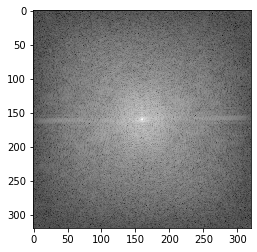

In [7]:
slice_kspace = T.fft2(slice_tensor)
slice_spectrum = torch.log(T.complex_abs(slice_kspace) + 1e-9)

plt.imshow(slice_spectrum[0], cmap='gray')

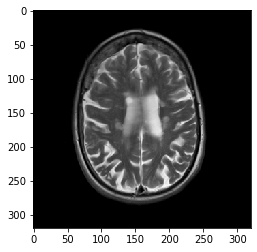

In [8]:
slice_image = T.ifft2(slice_kspace) 
slice_image_abs = T.complex_abs(slice_image)

slice_image_abs.shape
plt.imshow(slice_image_abs[0], 'gray')

In [9]:
mask_func = RandomMaskFunc(center_fractions=[0.08], accelerations=[4])
masked_kspace, mask = T.apply_mask(slice_kspace, mask_func)

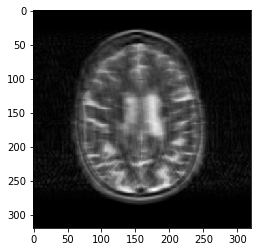

In [10]:
sampled_image = T.ifft2(masked_kspace)
sampled_image_abs = T.complex_abs(sampled_image)


plt.imshow(sampled_image_abs[0], cmap='gray')

In [11]:
compare_imgs(slice_image_abs/slice_image_abs.max(), sampled_image_abs/sampled_image_abs.max())

	MAE	PSNR	SSIM
score	0.04	24.04	0.65


[0.038789272, 24.04497406390123, 0.6494041533637485]